In [1]:
#! pip install transformers
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import transformers as ppb # pytorch transformers

from sklearn import metrics
from sklearn import kernel_ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_file = '../input/commonlitreadabilityprize/train.csv'
data_train =  pd.read_csv(train_file)
data_train = data_train[['excerpt', 'target']]
data_train

,excerpt,target
0,When the young people returned to the ballroom...,-0.340259
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372
2,"As Roger had predicted, the snow departed as q...",-0.580118
3,And outside before the palace a great garden w...,-1.054013
4,Once upon a time there were Three Bears who li...,0.247197
...,...,...
2829,When you think of dinosaurs and where they liv...,1.711390
2830,So what is a solid? Solids are usually hard be...,0.189476
2831,The second state of matter we will discuss is ...,0.255209
2832,Solids are shapes that you can actually touch....,-0.215279


In [3]:
# Load pretrained model/tokenizer Distilbert
model_class = ppb.DistilBertModel
tokenizer_class = ppb.DistilBertTokenizer
pretrained_weights = "../input/distilbertbaseuncased/"

tokenizer = tokenizer_class.from_pretrained(pretrained_weights,
                                            do_lower_case=True)
model = model_class.from_pretrained(pretrained_weights)

In [4]:
tokenized = data_train.excerpt.apply(
    (lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized.shape

(2834,)

In [5]:
max_len = 0
min_len = 1000
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
    if len(i) < min_len:
        min_len = len(i)

print('length of texts : {} -> {}'.format(min_len, max_len))

# padding : add 0 to reach max number of tokens for all sentences
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print('texts shape :', padded.shape)

length of texts : 158 -> 314
texts shape : (2834, 314)


In [6]:
# needed if padding has been done
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2834, 314)

In [7]:
# distilbert
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

last_hidden_states = []
batch_size = 200

start = time.time()
with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
          print('{} / {}'.format(i, len(input_ids)))
          ins = input_ids[i:i+batch_size]
          atts = attention_mask[i:i+batch_size]
          h = model(ins, attention_mask=atts)
          last_hidden_states.extend(h[0])
          
print('elapsed time : ', time.time() - start)
print('hidden states : ', len(last_hidden_states))

0 / 2834
200 / 2834
400 / 2834
600 / 2834
800 / 2834
1000 / 2834
1200 / 2834
1400 / 2834
1600 / 2834
1800 / 2834
2000 / 2834
2200 / 2834
2400 / 2834
2600 / 2834
2800 / 2834
elapsed time :  1022.4512009620667
hidden states :  2834


# Regression

In [8]:
def show_res(yTest, yPred):
    """plots result curves"""
    fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    xmin = np.min(yTest)-1
    xmax = np.max(yTest)+1
    axes[0].scatter(yTest, yPred, color='coral', s=1.5)
    axes[0].plot([xmin, xmax], [xmin, xmax])
    axes[0].set_xlabel('Y expected')
    axes[0].set_ylabel('Y prediction')
    axes[0].set_title('Prediction / observation')
  
    residuals = yTest - yPred
    moy_residuals = np.mean(residuals)
    lab = 'Mean residuals(' + str(np.round(moy_residuals, decimals=2)) + ')'

    xmin = np.min(yPred) - 1
    xmax = np.max(yPred) + 1
    axes[1].scatter(yPred,residuals, color='red', s=1.5)
    axes[1].plot([xmin, xmax], [0, 0], color='grey', alpha=0.5, linewidth=0.5)
    axes[1].plot([xmin, xmax], [moy_residuals, moy_residuals],
                 color='green',linewidth=0.5, label=lab)
    axes[1].set_xlabel('Y prediction')
    axes[1].set_ylabel('Residuals')
    axes[1].legend()
    axes[1].set_title('Residuals')
    
    plt.show()

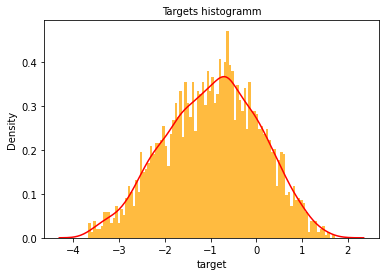

In [9]:
# get target labels
labels = data_train['target']

sns.histplot(data=data_train, x="target", bins=100, color='orange',
            edgecolor=None, stat='density',)
sns.kdeplot(data=data_train, x="target", color='red')
plt.title('Targets histogramm', fontsize=10)
plt.show()

# get features (cfs CLS token)
features = []
for i in range(len(last_hidden_states)):
    sent = last_hidden_states[i]
    first_hidden = sent[0]
    features.append(first_hidden.numpy())
features = np.array(features)

# split into train and validation set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

time (sec) : 0.24
rmse : 0.656


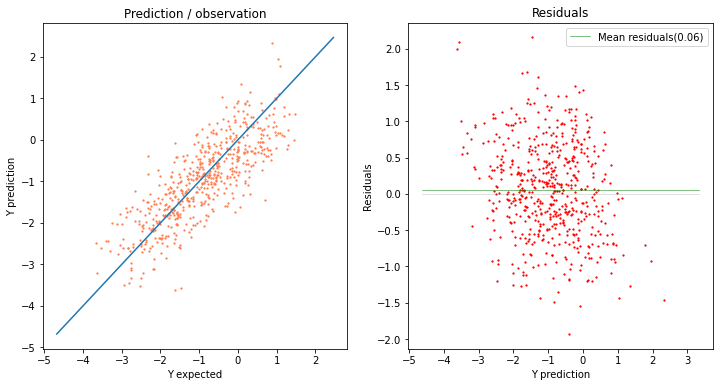

In [10]:
# Linear Regression

# training
start_time = time.time()
regr = LinearRegression().fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction
y_pred = regr.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# results
print('time (sec) :', round(elapsed, 2))
print('rmse :', round(rmse, 3))
show_res(y_test, y_pred)

time (sec) : 33.33
rmse : 0.565


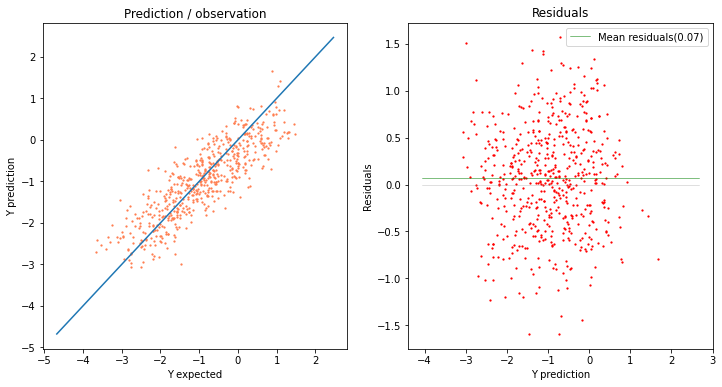

In [11]:
# Ridge polynomial kernel + gridsearch

# parameters C, gamma
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

score = 'neg_mean_squared_error'

kr_model = GridSearchCV(
        kernel_ridge.KernelRidge(kernel='polynomial'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# training
start_time = time.time()
kr_model.fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction
y_pred = kr_model.predict(X_test)
rmse_pol = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# results
print('time (sec) :', round(elapsed, 2))
print('rmse :', round(rmse_pol, 3))
show_res(y_test, y_pred)

# Test set (7 entries)

In [12]:
test_file = '../input/commonlitreadabilityprize/test.csv'
data_test =  pd.read_csv(test_file)

# tokenisation
tokenized_test = data_test.excerpt.str.lower().apply(
    (lambda x: tokenizer.encode(x, add_special_tokens=True)))

# padding
max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)

# padding : add 0 to reach max number of tokens for all sentences
padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
attention_mask_test = np.where(padded_test != 0, 1, 0)

# compute features
input_ids = torch.tensor(padded_test)  
attention_mask = torch.tensor(attention_mask_test)

last_hidden_states_test = []
batch_size = 200

start = time.time()
with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
          print('{} / {}'.format(i, len(input_ids)))
          ins = input_ids[i:i+batch_size]
          atts = attention_mask[i:i+batch_size]
          h = model(ins, attention_mask=atts)
          last_hidden_states_test.extend(h[0])
          
print('elapsed time : ', time.time() - start)
print('hidden states : ', len(last_hidden_states_test))

0 / 7
elapsed time :  1.4784636497497559
hidden states :  7


In [13]:
# test features
X_test = []
for i in range(len(last_hidden_states_test)):
    sent = last_hidden_states_test[i]
    first_hidden = sent[0]
    X_test.append(first_hidden.numpy())
X_test = np.array(X_test)

# prediction
y_test = kr_model.predict(X_test)

# submission file
submission_df = pd.DataFrame({'id': data_test.id, 'target': 0})
submission_df.target = y_test

submission_file = 'submission.csv'
submission_df.to_csv(submission_file, index=False)

submission_df

,id,target
0,c0f722661,-0.541981
1,f0953f0a5,-0.138987
2,0df072751,-0.295582
3,04caf4e0c,-2.707238
4,0e63f8bea,-1.772194
5,12537fe78,-1.036480
6,965e592c0,-0.370308
